## U-NET

Build [U-Net](https://arxiv.org/abs/1505.04597) with [TensorFlow 2](https://www.tensorflow.org/) and train a dataset annotated with [labelme](https://github.com/wkentaro/labelme).


### Parameters


In [1]:
import tensorflow as tf
import warnings

In [2]:
NUM_CLASSES = 5 # class number + 1 (background)
INPUT_SHAPE = [480, 640, 3] # (H, W, C)
BATCH_SIZE = 2
EPOCHS = 100
VAL_SUBSPLITS = 1

### Datasets


In [3]:
import math
import os
import numpy as np
from PIL import Image
import cv2


def cvtColor(image):
    if len(np.shape(image)) == 3 and np.shape(image)[-2] == 3:
        return image
    else:
        image = image.convert('RGB')
        return image


def normalize(image):
    image = image / 127.5 - 1
    return image


def resize_image(image, size):
    iw, ih = image.size
    w, h = size

    scale = min(w / iw, h / ih)
    nw = int(iw * scale)
    nh = int(ih * scale)

    image = image.resize((nw, nh), Image.BICUBIC)
    new_image = Image.new('RGB', size, (128, 128, 128))
    new_image.paste(image, ((w - nw) // 2, (h - nh) // 2))

    return new_image, nw, nh


def resize_label(image, size):
    iw, ih = image.size
    w, h = size

    scale = min(w / iw, h / ih)
    nw = int(iw * scale)
    nh = int(ih * scale)

    image = image.resize((nw, nh), Image.NEAREST)
    new_image = Image.new('L', size, (0))
    new_image.paste(image, ((w - nw) // 2, (h - nh) // 2))

    return new_image, nw, nh


class UnetDataset(tf.keras.utils.Sequence):

    def __init__(self, annotation_lines, input_shape, batch_size, num_classes,
                 train, dataset_path):
        self.annotation_lines = annotation_lines
        self.length = len(self.annotation_lines)
        self.input_shape = input_shape
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.train = train
        self.dataset_path = dataset_path

    def __len__(self):
        return math.ceil(len(self.annotation_lines) / float(self.batch_size))

    def __getitem__(self, index):
        images = []
        targets = []
        for i in range(index * self.batch_size, (index + 1) * self.batch_size):
            i = i % self.length
            name = self.annotation_lines[i].splitlines()[0]
            jpg = Image.open(
                os.path.join(os.path.join(self.dataset_path, "JPEGImages"),
                             name + ".jpg"))
            png = Image.open(
                os.path.join(
                    os.path.join(self.dataset_path, "SegmentationClassPNG"),
                    name + ".png"))

            jpg, png = self.process_data(jpg,
                                         png,
                                         self.input_shape,
                                         random=self.train)

            images.append(jpg)
            targets.append(png)

        images = np.array(images)
        targets = np.array(targets)
        return images, targets

    def rand(self, a=0, b=1):
        return np.random.rand() * (b - a) + a

    def process_data(self, image, label, input_shape, random=True):
        image = cvtColor(image)
        label = Image.fromarray(np.array(label))
        h, w, _ = input_shape

        # resize
        image, _, _ = resize_image(image, (w, h))
        label, _, _ = resize_label(label, (w, h))

        if random:
            # flip
            flip = self.rand() < .5
            if flip:
                image = image.transpose(Image.FLIP_LEFT_RIGHT)
                label = label.transpose(Image.FLIP_LEFT_RIGHT)

        # np
        image = np.array(image, np.float32)
        image = normalize(image)

        label = np.array(label)
        label[label >= self.num_classes] = self.num_classes

        return image, label

In [4]:
dataset_path = 'datasets/train_voc'

# read dataset txt files
with open(os.path.join(dataset_path, "ImageSets/Segmentation/train.txt"),
          "r",
          encoding="utf8") as f:
    train_lines = f.readlines()

with open(os.path.join(dataset_path, "ImageSets/Segmentation/val.txt"),
          "r",
          encoding="utf8") as f:
    val_lines = f.readlines()

train_batches = UnetDataset(train_lines, INPUT_SHAPE, BATCH_SIZE, NUM_CLASSES,
                            True, dataset_path)
val_batches = UnetDataset(val_lines, INPUT_SHAPE, BATCH_SIZE, NUM_CLASSES,
                          False, dataset_path)

STEPS_PER_EPOCH = len(train_lines) // BATCH_SIZE
VALIDATION_STEPS = len(val_lines) // BATCH_SIZE // VAL_SUBSPLITS

<ipython-input-3-f503d91d6c74>:29: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  image = image.resize((nw, nh), Image.BICUBIC)
<ipython-input-3-f503d91d6c74>:44: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  image = image.resize((nw, nh), Image.NEAREST)
<ipython-input-3-f503d91d6c74>:108: DeprecationWarning: FLIP_LEFT_RIGHT is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.FLIP_LEFT_RIGHT instead.
  image = image.transpose(Image.FLIP_LEFT_RIGHT)
<ipython-input-3-f503d91d6c74>:109: DeprecationWarning: FLIP_LEFT_RIGHT is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.FLIP_LEFT_RIGHT instead.
  label = label.transpose(Image.FLIP_LEFT_RIGHT)


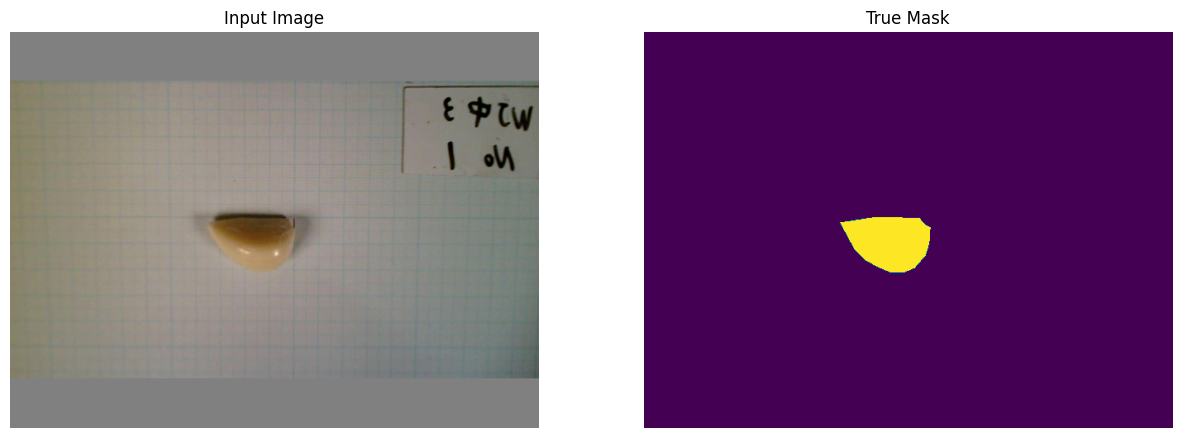

In [5]:
import matplotlib.pyplot as plt


def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()


images, masks = train_batches.__getitem__(0)
sample_image, sample_mask = images[0], masks[0]
sample_mask = sample_mask[..., tf.newaxis]
display([sample_image, sample_mask])

### Model


#### Helper methods


In [6]:
# https://www.tensorflow.org/tutorials/generative/pix2pix
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters,
                                        size,
                                        strides=2,
                                        padding='same',
                                        kernel_initializer=initializer,
                                        use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result


#### Base model


In [7]:
base_model = tf.keras.applications.MobileNetV2(input_shape=INPUT_SHAPE,
                                               include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',  # 64x64
    'block_3_expand_relu',  # 32x32
    'block_6_expand_relu',  # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',  # 4x4
]
base_model_outputs = [
    base_model.get_layer(name).output for name in layer_names
]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input,
                            outputs=base_model_outputs)

down_stack.trainable = False

up_stack = [
    upsample(512, 3),  # 4x4 -> 8x8
    upsample(256, 3),  # 8x8 -> 16x16
    upsample(128, 3),  # 16x16 -> 32x32
    upsample(64, 3),  # 32x32 -> 64x64
]


def unet_model(output_channels: int):
    inputs = tf.keras.layers.Input(shape=INPUT_SHAPE)

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(filters=output_channels,
                                           kernel_size=3,
                                           strides=2,
                                           padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)


#### Compile


In [8]:
model = unet_model(output_channels=NUM_CLASSES)
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 480, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             [(None, 240, 320, 9  1841984     ['input_2[0][0]']                
                                6),                                                               
                                 (None, 120, 160, 1                                               
                                44),                                                              
                                 (None, 60, 80, 192                                         

#### Callbacks

In [9]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]


def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([
            sample_image, sample_mask,
            create_mask(model.predict(sample_image[tf.newaxis, ...]))
        ])


from IPython.display import clear_output


class DisplayCallback(tf.keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print('\nSample Prediction after epoch {}\n'.format(epoch + 1))


class ModelCheckpointCallback(tf.keras.callbacks.Callback):

    def __init__(self,
                 filepath,
                 monitor='val_loss',
                 verbose=0,
                 save_best_only=False,
                 save_weights_only=False,
                 mode='auto',
                 period=1):
        super(ModelCheckpointCallback, self).__init__()
        self.monitor = monitor
        self.verbose = verbose
        self.filepath = filepath
        self.save_best_only = save_best_only
        self.save_weights_only = save_weights_only
        self.period = period
        self.epochs_since_last_save = 0

        if mode not in ['auto', 'min', 'max']:
            warnings.warn(
                'ModelCheckpoint mode %s is unknown, '
                'fallback to auto mode.' % (mode), RuntimeWarning)
            mode = 'auto'

        if mode == 'min':
            self.monitor_op = np.less
            self.best = np.Inf
        elif mode == 'max':
            self.monitor_op = np.greater
            self.best = -np.Inf
        else:
            if 'acc' in self.monitor or self.monitor.startswith('fmeasure'):
                self.monitor_op = np.greater
                self.best = -np.Inf
            else:
                self.monitor_op = np.less
                self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epochs_since_last_save += 1
        if self.epochs_since_last_save >= self.period:
            self.epochs_since_last_save = 0
            filepath = self.filepath.format(epoch=epoch + 1, **logs)
            if self.save_best_only:
                current = logs.get(self.monitor)
                if current is None:
                    warnings.warn(
                        'Can save best model only with %s available, '
                        'skipping.' % (self.monitor), RuntimeWarning)
                else:
                    if self.monitor_op(current, self.best):
                        if self.verbose > 0:
                            print(
                                '\nEpoch %05d: %s improved from %0.5f to %0.5f,'
                                ' saving model to %s' %
                                (epoch + 1, self.monitor, self.best, current,
                                 filepath))
                        self.best = current
                        if self.save_weights_only:
                            self.model.save_weights(filepath, overwrite=True)
                        else:
                            self.model.save(filepath, overwrite=True)
                    else:
                        if self.verbose > 0:
                            print('\nEpoch %05d: %s did not improve' %
                                  (epoch + 1, self.monitor))
            else:
                if self.verbose > 0:
                    print('\nEpoch %05d: saving model to %s' %
                          (epoch + 1, filepath))
                if self.save_weights_only:
                    self.model.save_weights(filepath, overwrite=True)
                else:
                    self.model.save(filepath, overwrite=True)

### Train

1/1 [==============================] - 0s 122ms/step


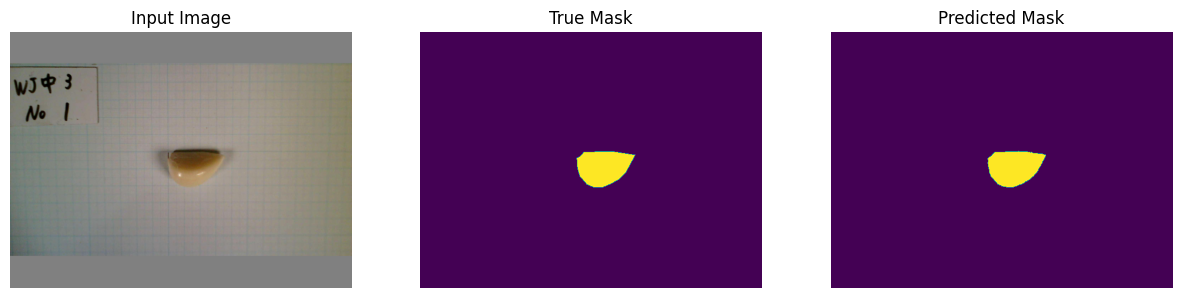


Sample Prediction after epoch 100

50/50 [==============================] - 26s 525ms/step - loss: 5.4030e-04 - accuracy: 0.9998 - val_loss: 0.0040 - val_accuracy: 0.9991


In [10]:
displayCallback = DisplayCallback()

if not os.path.exists('logs'):
    os.makedirs('logs')
checkpointCallback = ModelCheckpointCallback(
    'logs/ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss',
    save_weights_only=True,
    save_best_only=True,
    period=1)

model_history = model.fit(train_batches,
                          epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=val_batches,
                          callbacks=[displayCallback, checkpointCallback])

model.save('logs/the-last-model.h5', overwrite=True)

In [4]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

NameError: name 'model_history' is not defined

### Load Model


In [34]:
model_path = 'logs/the-last-model.h5'
model.load_weights(model_path)
print('{} model loaded.'.format(model_path))

import copy

colors = [(0, 0, 0), (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128),
          (128, 0, 128), (0, 128, 128), (128, 128, 128),
          (64, 0, 0), (192, 0, 0), (64, 128, 0), (192, 128, 0), (64, 0, 128),
          (192, 0, 128), (64, 128, 128), (192, 128, 128), (0, 64, 0),
          (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128),
          (128, 64, 12)]


def detect_image(image_path):
    image = Image.open(image_path)
    image = cvtColor(image)

    old_img = copy.deepcopy(image)
    ori_h = np.array(image).shape[0]
    ori_w = np.array(image).shape[1]

    image_data, nw, nh = resize_image(image, (INPUT_SHAPE[1], INPUT_SHAPE[0]))

    image_data = normalize(np.array(image_data, np.float32))

    image_data = np.expand_dims(image_data, 0)


    pr = model.predict(image_data)[0]

    pr = pr[int((INPUT_SHAPE[0] - nh) // 2) : int((INPUT_SHAPE[0] - nh) // 2 + nh), \
            int((INPUT_SHAPE[1] - nw) // 2) : int((INPUT_SHAPE[1] - nw) // 2 + nw)]

    pr = cv2.resize(pr, (ori_w, ori_h), interpolation=cv2.INTER_LINEAR)

    pr = pr.argmax(axis=-1)
    
    # calculate area
    contours, hierarchy = cv2.findContours(pr.astype(np.uint8), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    area = 0
    for i in range(len(contours)):
        if cv2.contourArea(contours[i]) < 100:
            continue
        else:
            area = cv2.contourArea(contours[i])   
    print("The area is:%.1f pixel" % area)
        
    # for c in range(NUM_CLASSES):
    #     seg_img[:, :, 0] += ((pr[:, :] == c ) * colors[c][0]).astype('uint8')
    #     seg_img[:, :, 1] += ((pr[:, :] == c ) * colors[c][1]).astype('uint8')
    #     seg_img[:, :, 2] += ((pr[:, :] == c ) * colors[c][2]).astype('uint8')
    seg_img = np.reshape(
        np.array(colors, np.uint8)[np.reshape(pr, [-1])], [ori_h, ori_w, -1])

    image = Image.fromarray(seg_img)
    image = Image.blend(old_img, image, 0.7)

    return image,area

logs/the-last-model.h5 model loaded.


### Test


1/1 [==============================] - 0s 121ms/step


<ipython-input-3-f503d91d6c74>:29: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  image = image.resize((nw, nh), Image.BICUBIC)


The area is:63386.5 pixel


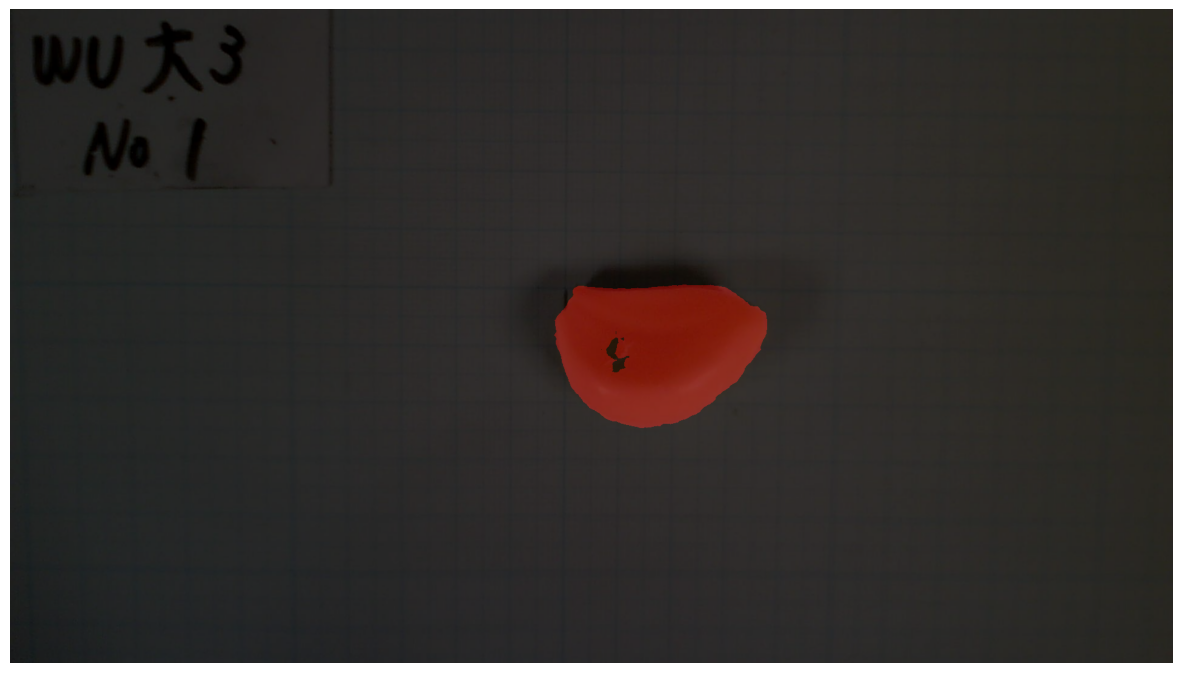

In [35]:
import os

test_image_path = 'datasets/test/WUB3 (1)63386.5.jpg'

# def rename(path):

#     for file in os.listdir(path):
        
#         data = detect_image(test_image_path+file)
#         area = data[1]
#         print(area)
        
#         if (file.startswith(file.split(".")[0])):
            
#             newName = file.replace(file.split(".")[0], file.split(".")[0] + str(area))

#             os.rename(os.path.join(path, file), os.path.join(path, newName))

# rename(test_image_path)

data = detect_image(test_image_path)
plt.figure(figsize=(15, 15))
plt.imshow(data[0])
plt.axis('off')
plt.show()